In [1]:
# 1 Importar as bibs necessárias e setar o device
from abc import ABC, abstractmethod
from typing import Optional
import math
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.axes._axes import Axes
import torch
import torch.distributions as D
from torch.func import vmap, jacrev
from tqdm import tqdm
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# 2 Definido método abstrato para o EDO 
class EDO(ABC):
    # Parte determinística da função, para EDO o coeficiente de difusão é igual a zero
    @abstractmethod
    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Retorna o coeficiente drift da EDO:
        Args:
        - xt: estado no tempo t, shape = (bs, dim)
        - t: tempo, shape = ()
        Retorna:
        -drift_coefficient: shape (bs, dim)
        """
        pass

# 3 Definido método abstrato para o EDE
class EDE(ABC):
    # Assim como a EDO, também possui uma parte determinística
    @abstractmethod
    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Retorna o coeficiente drift da EDO na EDE
        Args:
        - xt: estado no tempo t, shape = (bs, dim)
        - t: tempo, shape = ()
        Retorna:
        -drift_coefficient: shape = (bs, dim)  
        """
        pass
    # Coeficiente de difusão da EDE
    @abstractmethod
    def diffusion_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Retorna o coeficiente de difusão da EDE
        Args:
        -xt: estado no tempo t, shape = (bs, dim)
        -t: tempo, shape = ()
        Retorna:
        -diffusion_coefficient: shape = (bs, dim)
        """
        pass
        

In [3]:
# 4 Métodos numéricos para simular EDOs e EDEs 
class Simulator(ABC):
    @abstractmethod
    def step(self, xt: torch.Tensor, t: torch.Tensor, dt: torch.Tensor) -> torch.Tensor:
        """
        Corresponde a um passo (h) na simulação
        Args:
        -xt: estado no tempo t, shape=(bs, dim)
        -t: tempo t, shape=()
        -dt: tempo infinitesimal dt, shape=()
        Retorna:
        -nxt: próxima estado xt no tempo = t + dt, shape=(bs, dim)
        """
        pass

    # torch.no_grad para não computar gradientes (maior velocidade, a computação é necessária apenas durante treinamento)
    @torch.no_grad()        
    def simulate(self, x: torch.Tensor, ts: torch.Tensor):
        """
        Simulação usando discretização dado por ts
        Args:
        -x_init: estado x inicial no tempo ts[0], shape=(bs, dim)
        -ts: estados de tempo t, shape= (nts,),  nts = num_timesteps
        Retorna:
        x_final: estado x final no tempo ts[-1], shape=(bs,dim)
        
        """
        for t_idx in range(len(ts)-1):
            t = ts[t_idx]
            h = ts[t_idx + 1] - ts[t_idx] # h = dt
            x = self.step(x, t, h)        
        return x

    # simulação com trajetória
    @torch.no_grad()
    def simulate_with_trajectory(self, x:torch.Tensor, ts: torch.Tensor):
        """
        Simula usando a discretização de ts
        Args:
        -x_inicial: estado x inicial no tempo, ts[0], shape=(bs,dim)
        -ts: estados de tempo t, shape=(nts,)
        Retorna:
        xs: trajetória dos estados xts nos ts, shape=(bs, nts, dim)
        """
        xs = [x.clone()]
        for t_idx in tqdm(range(len(ts)-1)):
            t = ts[t_idx]
            h = ts[t_idx+1] - ts[t_idx]
            x = self.step(x, t, h)
            xs.append(x)
        return torch.stack(xs, dim=1)
            

In [4]:
# 5 Implementação do método de Euler
class EulerSimulator(Simulator):
    def __init__(self, edo: EDO):
        self.edo = edo

    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor):
        """
        Corresponde a um passo na simulação de Euler
        Args:
        -xt: estado no tempo t, shape=(bs, dim)
        -t: tempo t, shape=()
        -h: passo de tempo infinitesimal dt, shape=()
        Retorna:
        -nxt: próxima estado xt no tempo = t + h, shape=(bs, dim)
        Método de Euler:
        x_{t+h} = xt + h * u(xt)
        """
        drift_coefficient = self.edo.drift_coefficient(xt, t) # shape = (bs, dim)
        nxt = xt + h * drift_coefficient  # Euler step
        return nxt

# 6 Implementação do método de Euler-Maruyama
class EulerMaruyamaSimulator(Simulator):
    def __init__(self, ede: EDE):
        self.ede = ede

    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor):
        """
        Corresponde a um passo na simulação de EM
        Args:
        - xt: estado no tempo t, shape=(bs, dim)
        - t: tempo t, shape=()
        - h: passo de tempo infinitesimal dt, shape=()
        Retorna:
        -nxt: próximo estado xt no tempo = t + h, adicionado ao ruido estocástico.
        Método de Euler-Maruyama:
        x_{t+h} = xt + h * u(xt) + diffusion_coefficient*sqrt(h)epsilon, epsilon ~ N(0, I) -> shape=(bs, dim) = xt shape
        """
        drift_coefficient = self.ede.drift_coefficient(xt, t)
        diffusion_coefficient = self.ede.diffusion_coefficient(xt, t)
        nxt = xt + h * drift_coefficient + diffusion_coefficient * torch.sqrt(h) * torch.randn_like(xt)
        return nxt
        
        
   

    

In [5]:
# 6 Definir a classe para o movimento Browniano em X_{0} = 0
class BrownianMotion(EDE):
    """
    Movimento Browniano é definido como:
    dXt = sigma*dWt, X0 = 0.
    coeficiente de drift (h*u_{t}(xt)) é zero para o movimento browniano, pois u_{t}(xt) = 0
    """
    def __init__(self, sigma: float):
        self.sigma = sigma

    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Coeficiente drift para uma EDO
        Args:
        -xt: estado x no tempo t, shape = (bs, dim)
        -t: tempo t, shape=()
        Retorna:
        drift_coefficient, shape=(bs, dim)
        """
        return torch.zeros_like(xt)

    def diffusion_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Coeficiente de difusão para uma EDO
        Args:
        -xt: estado x no tempo t, shape=(bs,dim)
        -t: tempo t, shape=()
        Retorna:
        coeficiente de difusão, shape=(bs,dim)
        """
        return self.sigma * torch.ones_like(xt)

In [6]:
# 7 Simulando o movimento Browniano em 1D
def plot_trajectories_1d(x0: torch.Tensor, simulator: Simulator, timesteps: torch.Tensor, ax: Optional[Axes] = None):
    """
    Plota as trajetórias para uma EDE unidimensional, dado valores iniciais de x0 e dos timesteps
    Args:
    -x0: estado x no tempo t, shape=(num_trajectories, 1)
    - simulator: Objeto Simulator usado para a simulação
    - t: timesteps durante a simulação, shape=(num_timesteps,)
    -ax: Objeto pyplot Axes para plotar 
    """
    if ax is None:
        ax = plt.gca()
    trajectories = simulator.simulate_with_trajectory(x0, timesteps) # (num_trajectories, num_timesteps,...)
    for trajectory_idx in range(trajectories.shape[0]):
        trajectory = trajectories[trajectory_idx, :, 0] # (num_timesteps,)
        ax.plot(timesteps.cpu(), trajectory.cpu())

100%|█████████████████████████████████████████████████████████████████████████████| 499/499 [00:00<00:00, 11402.22it/s]


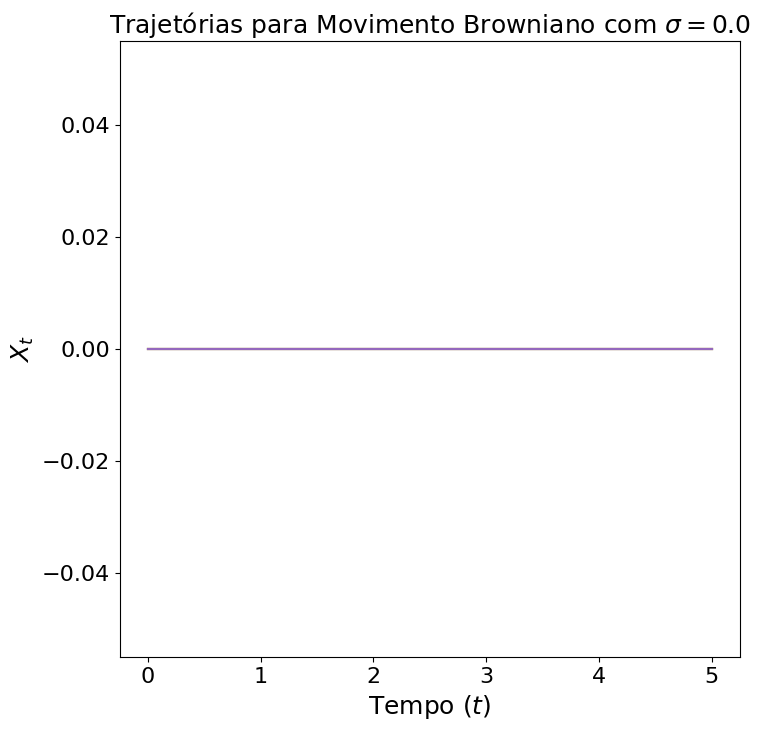

100%|█████████████████████████████████████████████████████████████████████████████| 499/499 [00:00<00:00, 46399.84it/s]


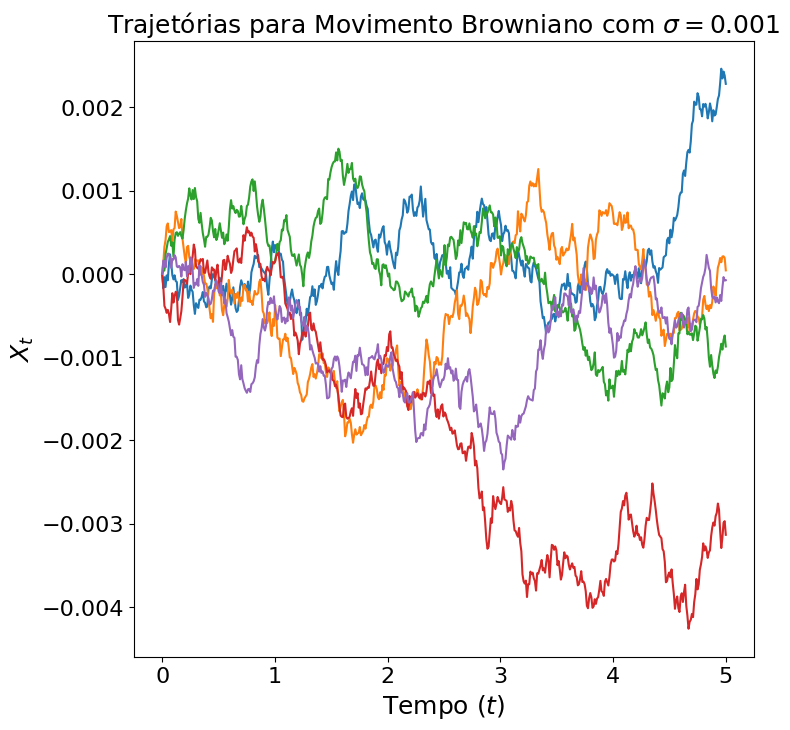

100%|█████████████████████████████████████████████████████████████████████████████| 499/499 [00:00<00:00, 12707.00it/s]


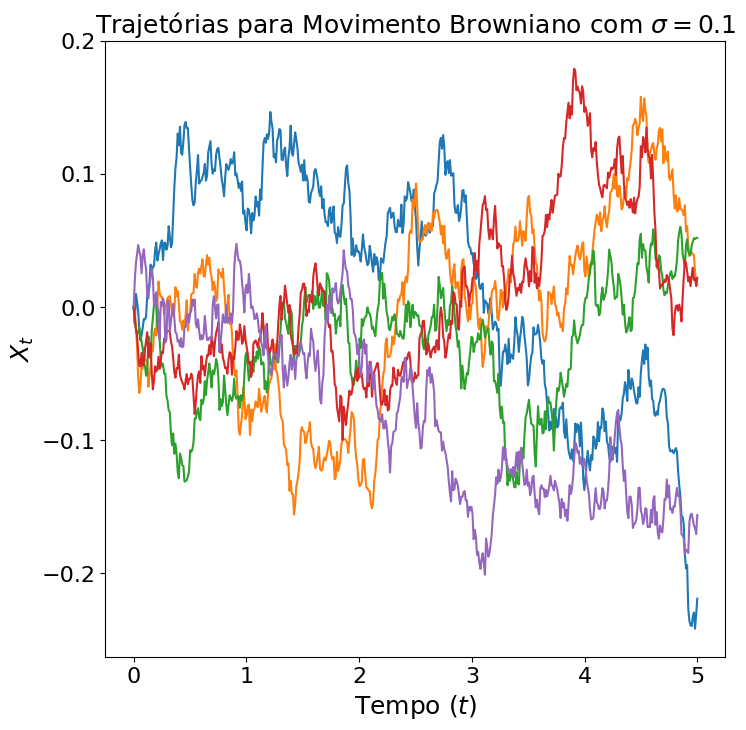

100%|█████████████████████████████████████████████████████████████████████████████| 499/499 [00:00<00:00, 15229.26it/s]


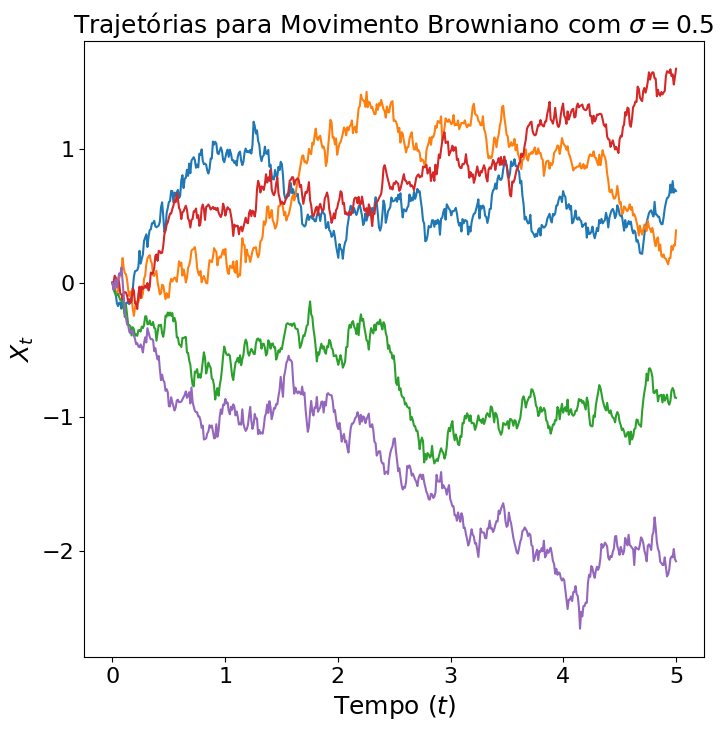

100%|█████████████████████████████████████████████████████████████████████████████| 499/499 [00:00<00:00, 18737.14it/s]


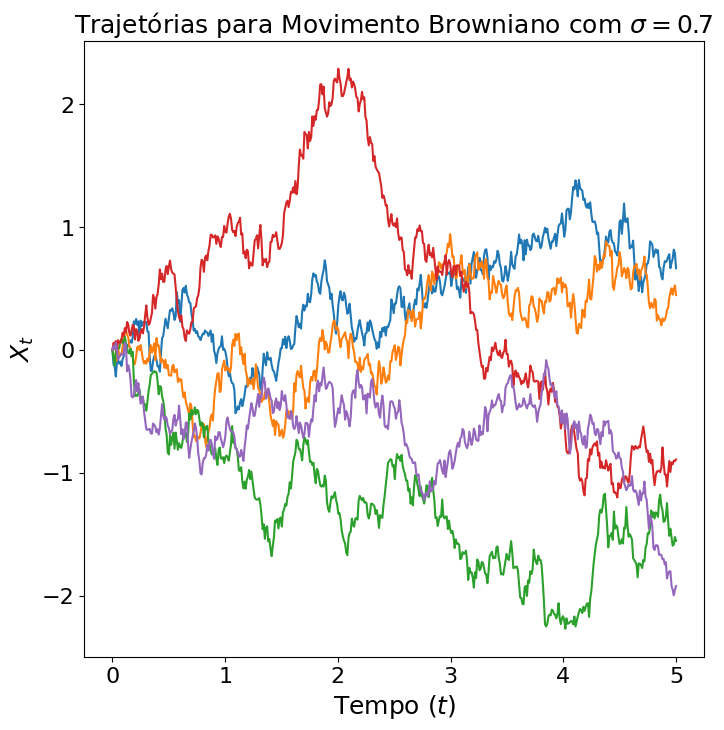

100%|█████████████████████████████████████████████████████████████████████████████| 499/499 [00:00<00:00, 20731.38it/s]


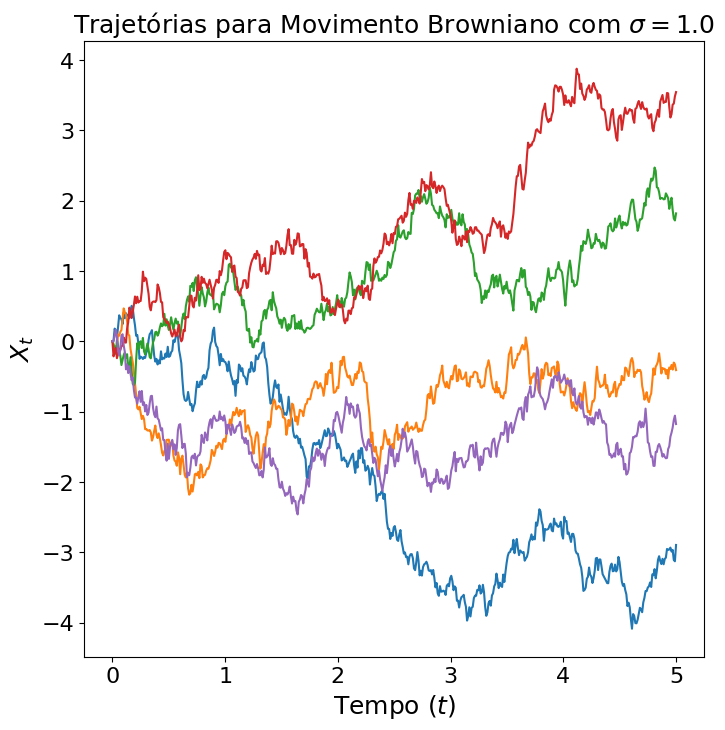

In [7]:
# 7 Simulando o movimento Browniano em 1D
sigma = [0.00, 0.001, 0.1, 0.5, 0.7, 1.0]
for s in sigma:
    brownian_motion = BrownianMotion(s)
    simulator = EulerMaruyamaSimulator(ede=brownian_motion)
    x0 = torch.zeros(5, 1).to(device) # Valores iniciais começando em x0 = 0
    ts = torch.linspace(0.0, 5.0, steps=500) # timesteps para simulação
    
    plt.figure(figsize=(8,8))
    ax = plt.gca()
    ax.set_title(r'Trajetórias para Movimento Browniano com $\sigma=$' + str(s), fontsize=18)
    ax.set_xlabel(r'Tempo ($t$)', fontsize=18)
    plt.xticks(fontsize=16)
    ax.set_ylabel(r'$X_{t}$', fontsize=18)
    plt.yticks(fontsize=16)
    plot_trajectories_1d(x0, simulator, ts, ax)
    plt.show()

In [8]:
# 8 Implementando o método de Ornstein-Uhlenbeck (OU)
class OUMethod(EDE):
    def __init__(self, theta: float, sigma: float):
        self.theta = theta
        self.sigma = sigma

    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Implementação do drift_coefficient para o Método Ou
        Args:
        -xt: estado x no tempo t, shape=(bs, dim)
        -t: tempo t, shape=()
        Retorna:
        drift coefficient: shape=(bs, dim)
        """
        return -self.theta * xt
        
    def diffusion_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Implementação do diffusion_coefficient para o Método Ou
        Args:
        -xt: estado x no tempo t, shape=(bs, dim)
        -t: tempo t, shape=()
        Retorna diffusion_coefficient: shape=(bs, dim) 
        """
        return self.sigma * torch.ones_like(xt)

<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
C:\Users\rafae\AppData\Local\Temp\ipykernel_37328\1116418285.py:20: SyntaxWarning: invalid escape sequence '\s'
  ax.set_title(f'Trajetórias para Método OU com $\sigma = ${sigma}, $\\theta = ${theta}', fontsize=15)
100%|█████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 18550.57it/s]


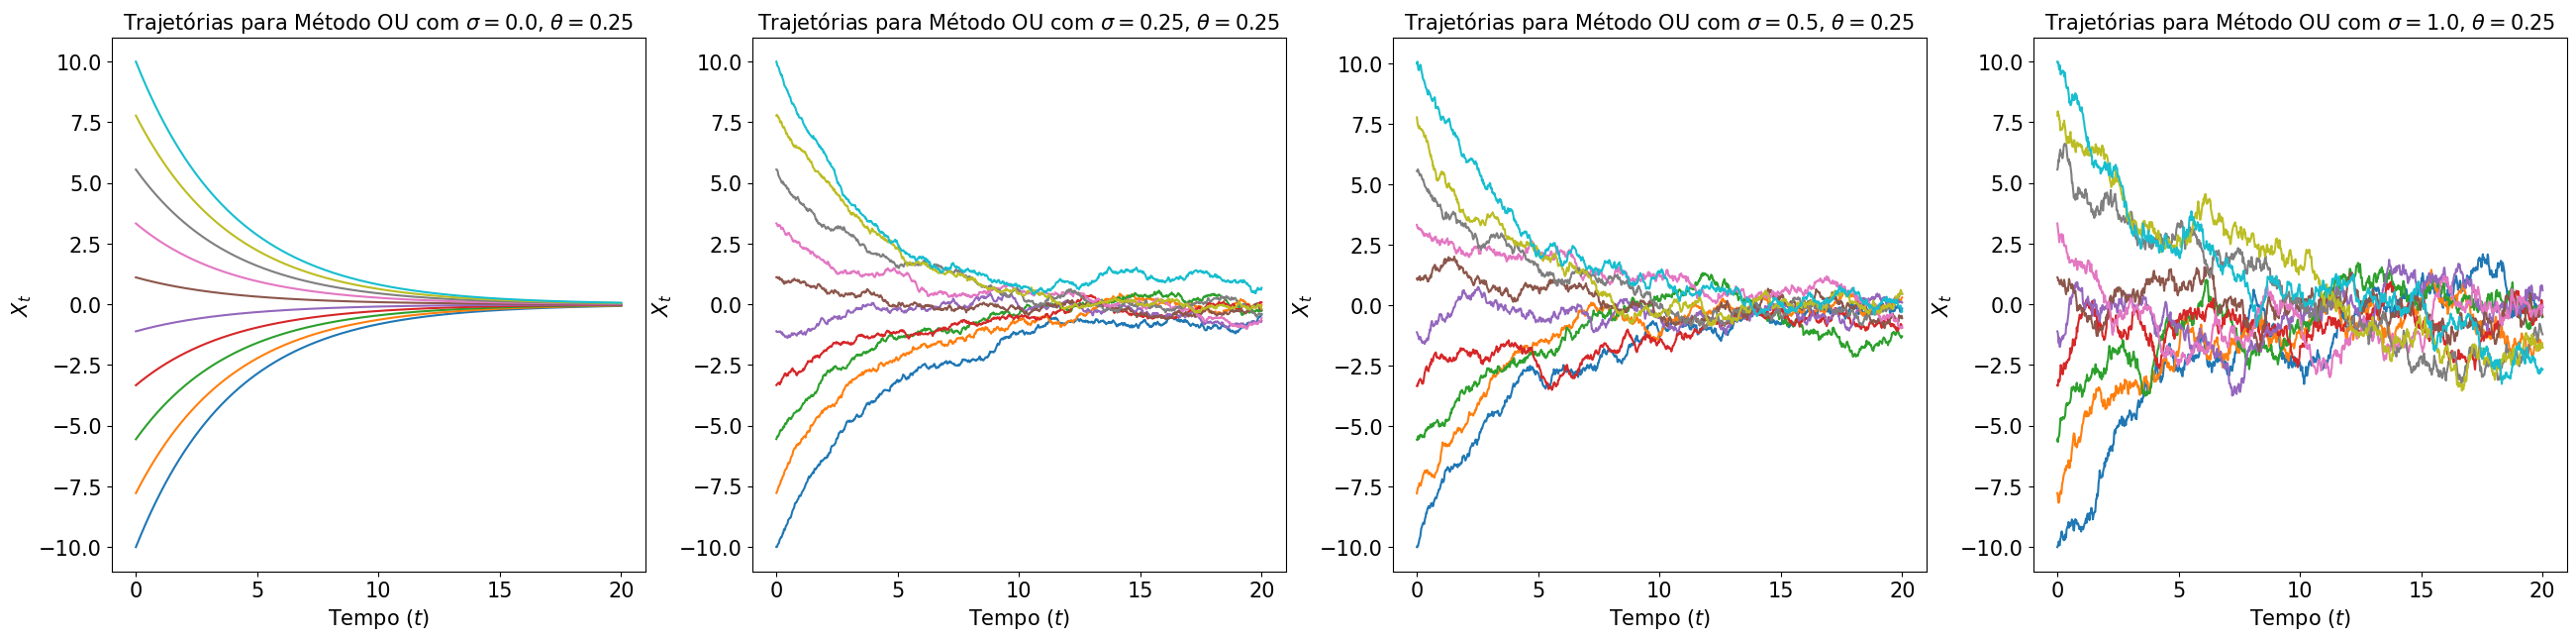

In [9]:
# 9 Teste com do Método OU com múltiplas opções
thetas_and_sigmas = [
    (0.25, 0.0),
    (0.25, 0.25),
    (0.25, 0.5), 
    (0.25, 1.0),
]
simulation_time = 20.0

num_plots = len(thetas_and_sigmas)
fig, axes = plt.subplots(1, num_plots, figsize=(8 * num_plots, 7))

for idx, (theta, sigma) in enumerate(thetas_and_sigmas):
    ou_method = OUMethod(theta, sigma)
    simulator = EulerMaruyamaSimulator(ede=ou_method)
    x0 = torch.linspace(-10.0, 10.0, 10).view(-1, 1).to(device) # Valores iniciais comezando em 0
    ts = torch.linspace(0.0, simulation_time, 1000).to(device) # Timesteps para simulação

    ax = axes[idx]
    ax.set_title(f'Trajetórias para Método OU com $\sigma = ${sigma}, $\\theta = ${theta}', fontsize=15)
    ax.set_xlabel(r'Tempo ($t$)', fontsize=15)
    ax.tick_params(axis='x', labelsize=15)
    ax.set_ylabel(r'$X_{t}$', fontsize=15)
    ax.tick_params(axis='y', labelsize=15)
    plot_trajectories_1d(x0, simulator, ts, ax)
plt.show()

In [14]:
# 8 pequena alteração na função plot_trajectories_1d
def plot_scaled_trajectories_1d(x0: torch.Tensor, simulator: Simulator, timesteps: torch.Tensor, time_scale: float, label: str, ax: Optional[Axes] = None):
    """
    Plota as trajetórias para uma EDE unidimensional, dado valores iniciais de x0 e dos timesteps
    Args:
    -x0: estado x no tempo t, shape=(num_trajectories, 1)
    - simulator: Objeto Simulator usado para a simulação
    - t: timesteps durante a simulação, shape=(num_timesteps,)
    - time_scale: fator para escalar o tempo, t
    - label: legenda para gráfico
    -ax: Objeto pyplot Axes para plotar 
    """
    if ax is None:
        ax = plt.gca()
    trajectories = simulator.simulate_with_trajectory(x0, timesteps) # (num_trajectories, num_timesteps,...)
    for trajectory_idx in range(trajectories.shape[0]):
        trajectory = trajectories[trajectory_idx, :, 0] # (num_timesteps,)
        ax.plot(timesteps.cpu() * time_scale, trajectory.cpu(), label=label)

100%|█████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 17954.79it/s]


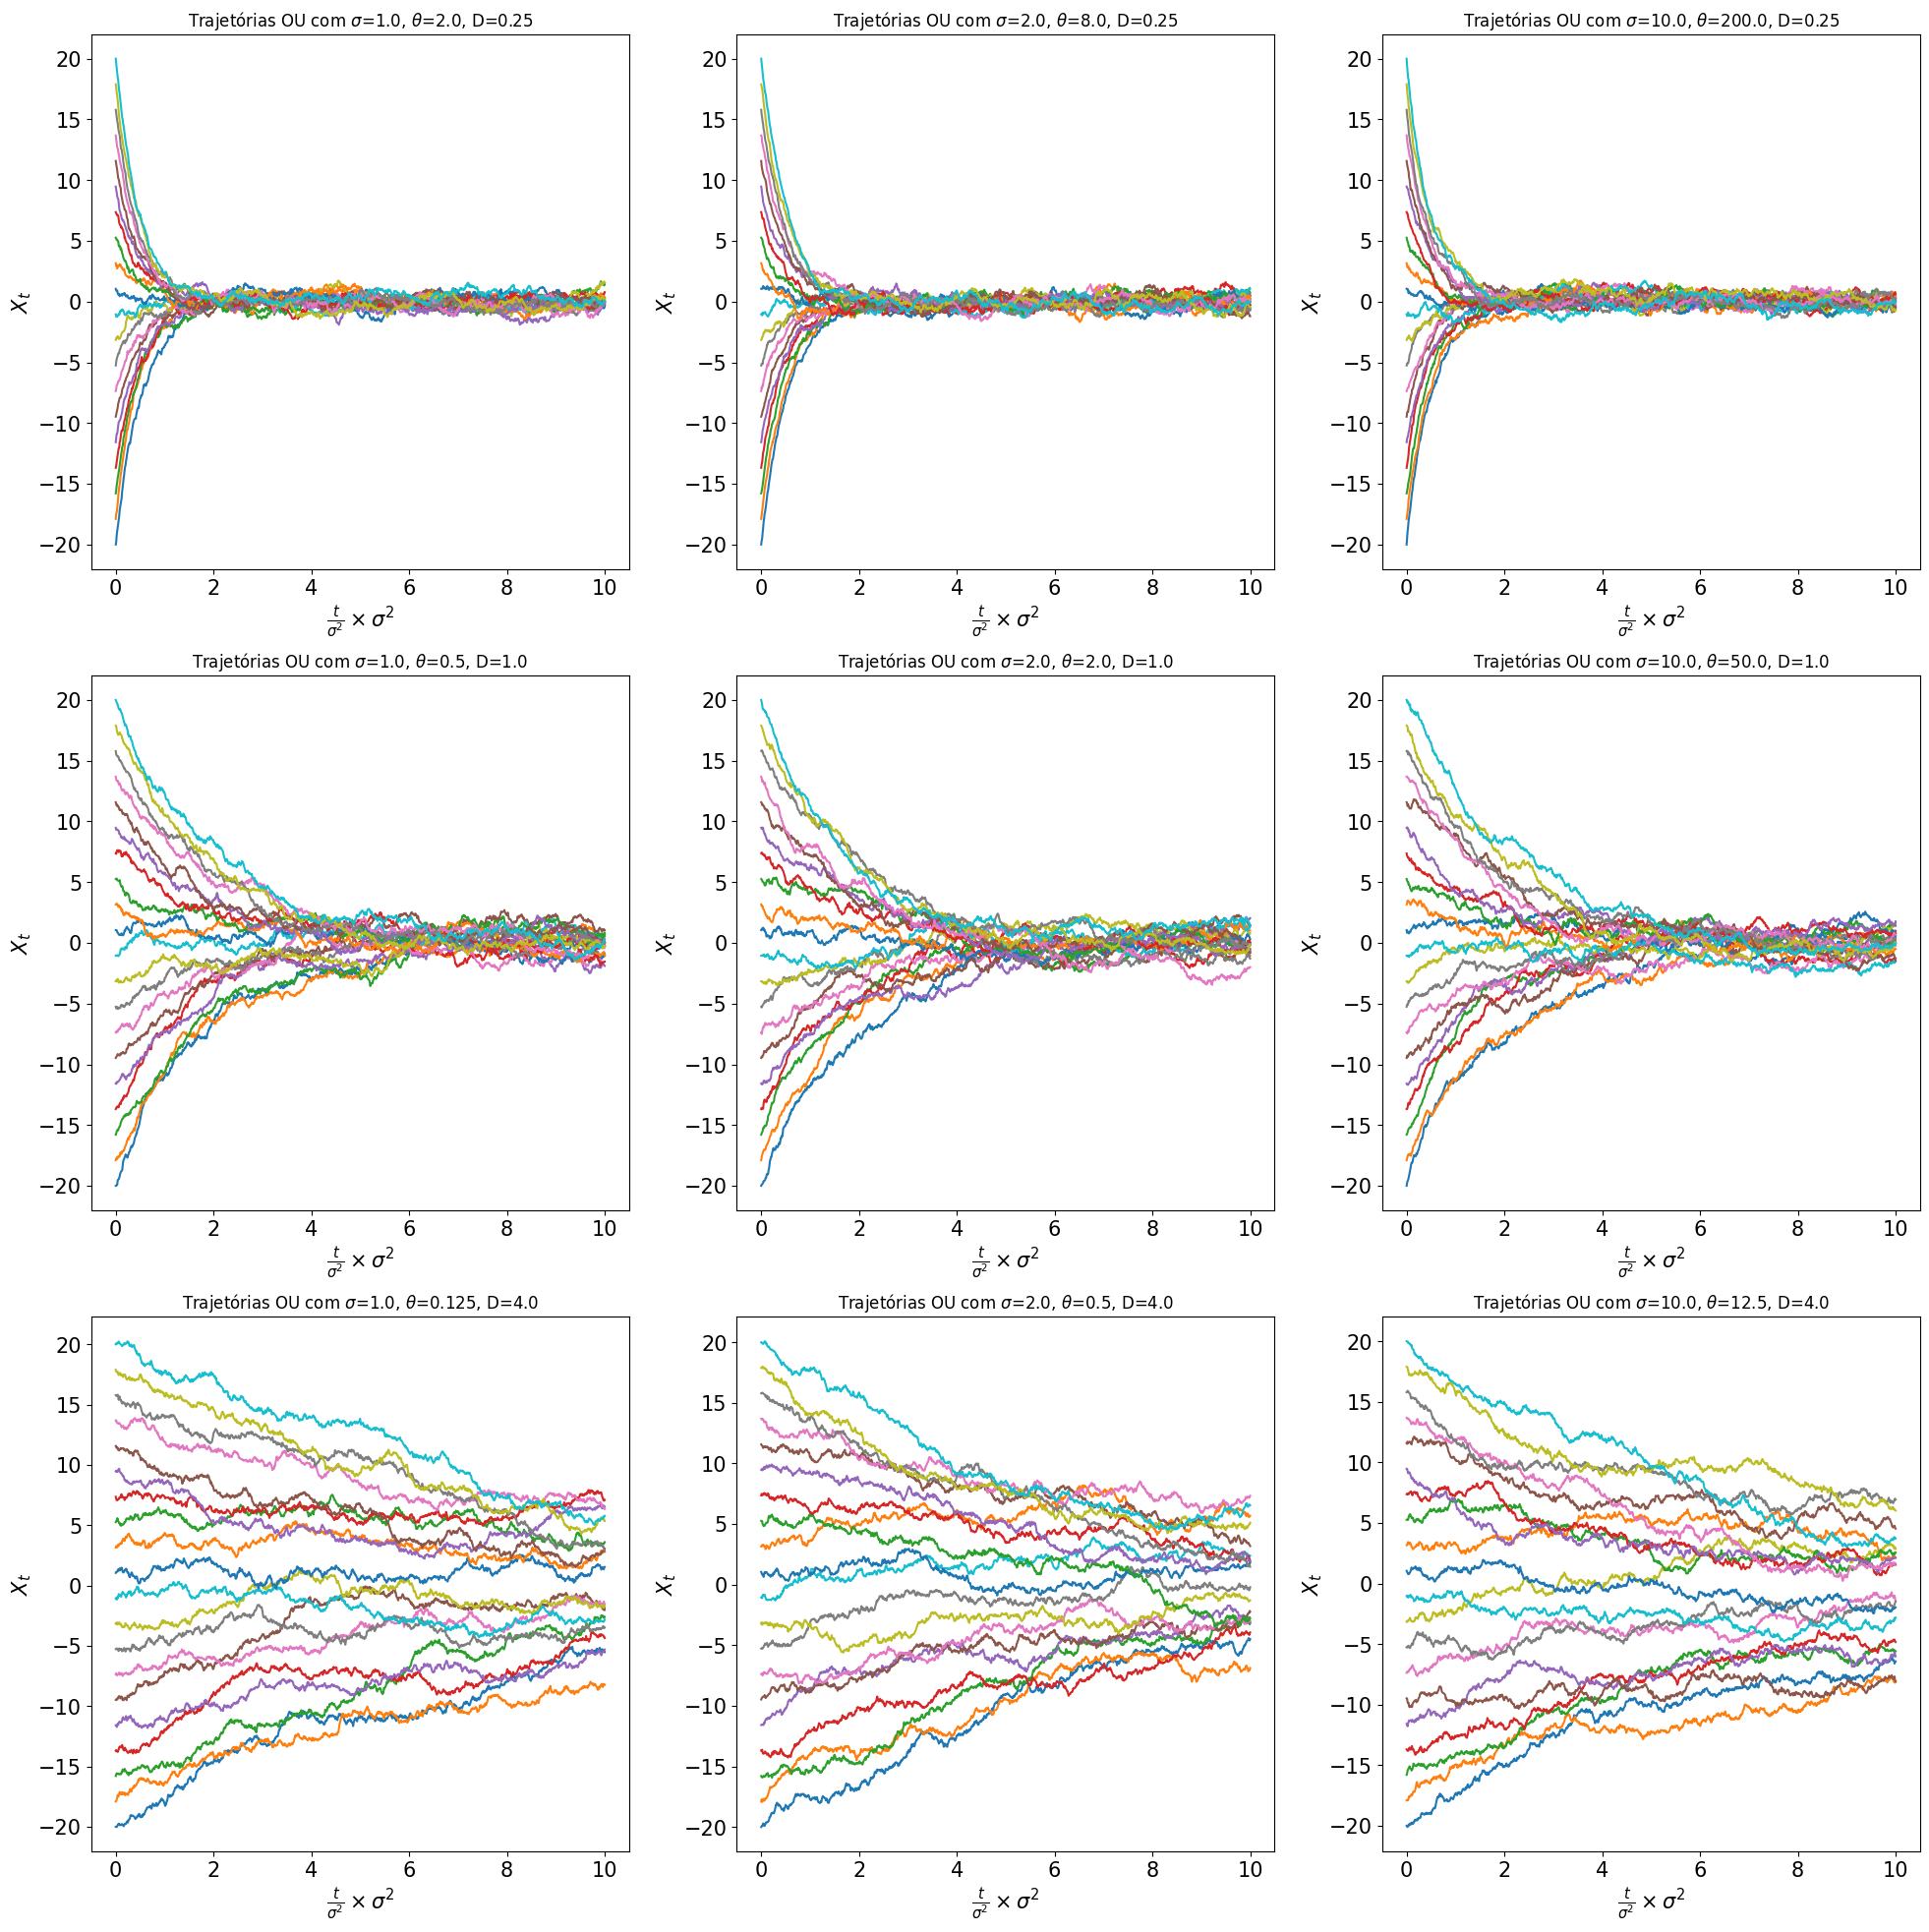

In [38]:
# Reescalando com o tempo
sigmas = [1.0, 2.0, 10.0]
# O coeficiente de difusão efetiva (D) é obtido a partir da variância de Xt ao longo do tempo (regime estacionário)
# Var[Xt] -> \sigma^{2} / 2*\Theta = D, t -> \infty
ds = [0.25, 1.0, 4.0] # Diferentes valores para o coeficiente de difusão efetiva D = \sigma^{2} / 2*\Theta
simulation_time = 10.0

fig, axes = plt.subplots(len(ds), len(sigmas), figsize=(8* len(sigmas), 8 * len(ds)))
axes = axes.reshape((len(ds), len(sigmas))) # 3 x 3
for d_idx, d in enumerate(ds):
    for s_idx, sigma in enumerate(sigmas):
        theta = sigma**2 / (2*d) # Rearranjando a expressão D = \sigma^2 / (2 * \Theta) -> \Theta = \sigma^2 / (2 * \Theta)
        ou_method = OUMethod(theta, sigma)
        simulator = EulerMaruyamaSimulator(ede=ou_method)
        x0 = torch.linspace(-20.0, 20.0, 20).view(-1, 1).to(device)
        time_scale = sigma**2
        ts = torch.linspace(0.0, simulation_time / time_scale, 1000).to(device) # simulation timesteps
        ax = axes[d_idx, s_idx]
        plot_scaled_trajectories_1d(x0=x0, simulator=simulator, timesteps=ts, time_scale=time_scale, label=f'Sigma = {sigma}', ax=ax)
        ax.set_title(fr'Trajetórias OU com $\sigma$={sigma}, $\theta$={theta}, D={d}')
        ax.set_xlabel(r'$\frac{t}{\sigma^2} \times \sigma^2$', fontsize=15)
        ax.set_ylabel('$X_{t}$', fontsize=15)
        ax.tick_params(axis='x', labelsize=15)
        ax.tick_params(axis='y', labelsize=15)
plt.show()